# "지하철 이용승객 분석" EDA 프로젝트(1)
- 이번 프로젝트에서는 EDA가 무엇이고 , 실습을 통해 EDA 하는 방법을 배워보겠습니다.
- EDA(Exploratory Data Analysis 탐색적 데이터 분석)는 데이터를 이해하는 과정이며 
- 통계적 요약, 분포 파악 및 시각화 등의 기법을 통해 직관적으로 데이터 특성 파악 할수 있습니다.
- 결국, EDA를 통해 데이터에서 트랜드 분석, 인사이트 도출하게 됩니다. 


## EDA 실습을 통해 해결해야 할 질문들
 
- 2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하자총승객수)
- 1월~6월중에 5월에 지하철 승객수가 많다? (기준 :승하자총승객수)
- 요일중에서 목요일에 지하철 승객수가 많다? (기준 :승하자총승객수)
- 일자별(월일별) 승하차승객수 그래프 그려 볼까요? (기준 :승하자총승객수)
- 가장 승객이 많이 타는 승차역은?
- 노선별로 역별/요일별 승차승객수를 비교해 볼수 있을까? (1~9호선, 역별/요일별 heatmap)
- 1호선에서 가장 하자를 많이 하는 역은? (groupby)
- 2호선중에서 어느 역에서 승차가 가장 많이 발생할까? (Folium 역 표시)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
import numpy as np
from matplotlib import font_manager, rc
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', size=8)

# 파일 관리 

In [49]:
pd.read_csv(r'C:\Users\hyssk\OneDrive\바탕 화면\003.지하철 이용승객 EDA분석_숙제_20220914\실습\rawfiles\CARD_SUBWAY_MONTH_201902.csv')

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20190201,6호선,이태원,15786.0,21324.0,20190204
1,20190201,6호선,한강진,9085.0,10665.0,20190204
2,20190201,6호선,버티고개,2660.0,2486.0,20190204
3,20190201,3호선,약수,4245.0,4396.0,20190204
4,20190201,5호선,청구,4236.0,4612.0,20190204
...,...,...,...,...,...,...
16538,20190228,2호선,을지로4가,6128.0,7087.0,20190303
16539,20190228,2호선,동대문역사문화공원,3387.0,4061.0,20190303
16540,20190228,5호선,청구,4920.0,4474.0,20190303
16541,20190228,1호선,가산디지털단지,51729.0,52043.0,20190303


In [57]:
def concat_dfs(folder_path:str , number:int = 1) -> pd.DataFrame:
    '''
    CSV 파일들이 담겨있는 절대 경로를 str 형태로 입력
    Path로 변형한 뒤 폴더 내에 있는 모든 CSV 파일들을 리스트로 표현
    number째 까지 데이터프레임을 concat 하기
    '''
    if Path.is_dir(Path(folder_path)): # 폴더명이 존재
        final = pd.DataFrame()
        folder_path = list(Path(folder_path).glob('*.csv'))
        for df_path in folder_path[:number]:
            temp = pd.read_csv(df_path)
            final = pd.concat([final,temp],ignore_index=True)
        return final
    else: # 폴더명이 존재하지 않음
        print('폴더명이 잘못되었습니다. 다시 입력해주세요.')

In [73]:
dataframe = concat_dfs(r'C:\Users\hyssk\OneDrive\바탕 화면\003.지하철 이용승객 EDA분석_숙제_20220914\실습\rawfiles',6)

# 2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하자총승객수)

## 사용일자, 등록일자 칼럼을 to_datetime으로 변경

In [74]:
dataframe['사용일자'] = pd.to_datetime(dataframe['사용일자'], format='%Y%m%d')
dataframe['등록일자'] = pd.to_datetime(dataframe['등록일자'], format='%Y%m%d')
dataframe

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,2019-01-01,2호선,을지로4가,3862.0,3728.0,2019-01-04
1,2019-01-01,3호선,을지로3가,8104.0,7554.0,2019-01-04
2,2019-01-01,2호선,을지로입구,22478.0,21330.0,2019-01-04
3,2019-01-01,2호선,시청,8381.0,6049.0,2019-01-04
4,2019-01-01,6호선,동묘앞,8045.0,8504.0,2019-01-04
...,...,...,...,...,...,...
107023,2019-06-30,7호선,마들,6622.0,6116.0,2019-07-03
107024,2019-06-30,4호선,노원,14071.0,14702.0,2019-07-03
107025,2019-06-30,7호선,중계,9516.0,8981.0,2019-07-03
107026,2019-06-30,7호선,하계,11645.0,11121.0,2019-07-03


In [80]:
dataframe['월일'] = dataframe['사용일자'].dt.strftime('%m-%d')
dataframe['연월'] = dataframe['사용일자'].dt.strftime('%Y-%m')
dataframe['요일'] = dataframe['사용일자'].dt.dayofweek

In [85]:
dataframe['요일'] = dataframe['요일'].map({0: '월',
                        1:'화',
                        2:'수',
                        3:'목',
                        4:'금',
                        5:'토',
                        6:'일'})

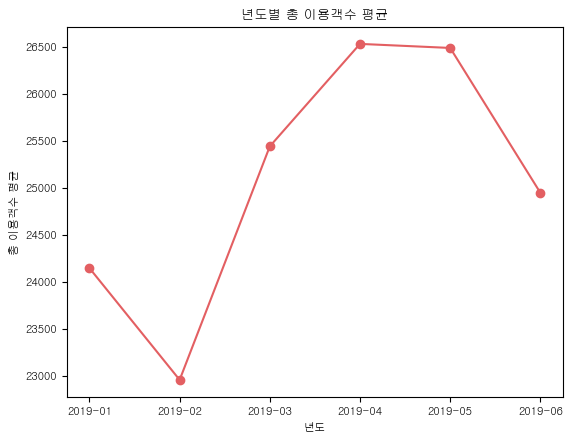

In [143]:
dataframe['총 이용객수'] = dataframe['승차총승객수'] + dataframe['하차총승객수']
q_1=dataframe.groupby('연월').mean()['총 이용객수']
plt.figure()
plt.scatter(q_1.index,q_1.values,color='#e35f62')
plt.plot(q_1.index,q_1.values,color='#e35f62')
plt.xlabel('년도')
plt.ylabel('총 이용객수 평균')
plt.title('년도별 총 이용객수 평균')
plt.show()

